# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `dataproject.py` file includes a function which will be used multiple times in this notebook.

Imports and set magics:

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2 # install with pip install matplotlib-venn
import pydst
import geopandas as gpd
import descartes

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import dataproject
dst = pydst.Dst(lang='en')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

## Employment data

In [2]:
dst.get_subjects()

# a. load
#empl = pd.read_excel('RAS200.xlsx', skiprows=2)

# b. drop columns
#drop_these = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3']
#empl.drop(drop_these, axis=1, inplace=True)

# c. rename columns
#empl.rename(columns = {'Unnamed: 4':'municipality'}, inplace=True)

,id,desc,active,hasSubjects
0,02,Population and elections,True,True
1,05,Living conditions,True,True
2,03,Education and knowledge,True,True
3,18,Culture and National Church,True,True
4,04,"Labour, income and wealth",True,True
5,06,Prices and consumption,True,True
6,14,National accounts and government finances,True,True
7,16,Money and credit market,True,True
8,13,External economy,True,True
9,07,Business sector in general,True,True


The dataset now looks like this:

In [3]:
dst.get_tables(subjects=['01'])
LIVO1_vars = dst.get_variables(table_id='LIVO1')
LIVO1_vars

LIVO1 = dst.get_data(table_id = 'LIVO1', variables={'OMRÅDE':['*'], 'TID':['*'],'AKTP':['O1'] })
LIVO1.sort_values(by=['OMRÅDE', 'TID'], ascending=False)
LIVO1



,OMRÅDE,TID,AKTP,INDHOLD
0,All Denmark,2008,Life expectancy (years),78.5
1,Region Nordjylland,2008,Life expectancy (years),78.5
2,Region Midtjylland,2008,Life expectancy (years),79.0
3,Region Syddanmark,2008,Life expectancy (years),78.8
4,Region Hovedstaden,2008,Life expectancy (years),78.2
...,...,...,...,...
1139,Rebild,2018,Life expectancy (years),80.8
1140,Mariagerfjord,2018,Life expectancy (years),80.4
1141,Jammerbugt,2018,Life expectancy (years),80.8
1142,Aalborg,2018,Life expectancy (years),80.6


In [4]:
lvt_en=LIVO1.rename(columns={"OMRÅDE": "municipality", "TID": "YEAR", "INDHOLD": "AVERAGE LIFESPAN", })
#imm_en = dataproject.only_keep_municipalities(imm_en)
lvt_en = dataproject.only_keep_municipalities(lvt_en)

list(lvt_en["YEAR"].value_counts().index)
lvt_en.drop(["AKTP"], axis=1, inplace=True)

lvt_en

,municipality,YEAR,AVERAGE LIFESPAN
6,Copenhagen,2008,75.6
7,Frederiksberg,2008,78.0
8,Ballerup,2008,77.6
9,Brøndby,2008,77.4
10,Dragør,2008,80.3
...,...,...,...
1139,Rebild,2018,80.8
1140,Mariagerfjord,2018,80.4
1141,Jammerbugt,2018,80.8
1142,Aalborg,2018,80.6


**Convert the dataset to long format**:

## Income data

In [5]:
indk_vars = dst.get_variables(table_id='INDKP101')
for id in ['ENHED','INDKOMSTTYPE','Tid']:
    print(id)
    values = indk_vars.loc[indk_vars.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')
        
INDKP101_vars = dst.get_variables(table_id='INDKP101')
INDKP101_vars

INDKP101 = dst.get_data(table_id = 'INDKP101', variables={'OMRÅDE':['*'],'INDKOMSTTYPE':['105'],'Tid':['*'],'ENHED':['116']})
INDKP101


ENHED
 id = 101, text = People with type of income (number)
 id = 110, text = Amount of income (DKK 1.000)
 id = 116, text = Average income for all people (DKK)
 id = 121, text = Average income for people with type of income (DKK)
INDKOMSTTYPE
 id = 100, text = 1 Disposable income (2+30-31-32-35)
 id = 105, text = 2 Pre-tax Income, total (3+7+22+26+29)
 id = 110, text = 3 Primary income (4+5+6)
 id = 115, text = 4 Wages and salaries etc., total
 id = 120, text = 5 Entrepreneurial income, total
 id = 125, text = 6 Received fees subject to labour market contributions
 id = 130, text = 7 Public transfer incomes(8+14+19)
 id = 135, text = 8 Unemployment and cash benefits (9+10+11+12+13)
 id = 140, text = 9 Unemployment benefits
 id = 145, text = 10 Other benefits from unemployment funds
 id = 150, text = 11 Cash benefits
 id = 155, text = 12 Job training & Limited employment benefits
 id = 160, text = 13 Sickness- & parental leave
 id = 165, text = 14 Other transfers(15+16+17+18)
 id = 170

,OMRÅDE,INDKOMSTTYPE,TID,ENHED,KOEN,INDHOLD
0,Assens,"2 Pre-tax Income, total (3+7+22+26+29)",2012,Average income for all people (DKK),"Men and women, total",267784
1,Faaborg-Midtfyn,"2 Pre-tax Income, total (3+7+22+26+29)",2012,Average income for all people (DKK),"Men and women, total",264002
2,Kerteminde,"2 Pre-tax Income, total (3+7+22+26+29)",2012,Average income for all people (DKK),"Men and women, total",269904
3,Nyborg,"2 Pre-tax Income, total (3+7+22+26+29)",2012,Average income for all people (DKK),"Men and women, total",267072
4,Odense,"2 Pre-tax Income, total (3+7+22+26+29)",2012,Average income for all people (DKK),"Men and women, total",260813
...,...,...,...,...,...,...
3515,Morsø,"2 Pre-tax Income, total (3+7+22+26+29)",2017,Average income for all people (DKK),"Men and women, total",277524
3516,Thisted,"2 Pre-tax Income, total (3+7+22+26+29)",2017,Average income for all people (DKK),"Men and women, total",289210
3517,Brønderslev,"2 Pre-tax Income, total (3+7+22+26+29)",2017,Average income for all people (DKK),"Men and women, total",292397
3518,Frederikshavn,"2 Pre-tax Income, total (3+7+22+26+29)",2017,Average income for all people (DKK),"Men and women, total",290973


In [6]:
inc_en=INDKP101.rename(columns={"OMRÅDE": "municipality", "TID": "YEAR", "INDHOLD": "INCOME","INDKOMSTTYPE":"TYPE OF INCOME","KOEN":"SEX" })
inc_en = dataproject.only_keep_municipalities(inc_en)
inc_en = inc_en.loc[inc_en["YEAR"]>=2008]
inc_en.drop(["ENHED", "SEX","TYPE OF INCOME"], axis=1, inplace=True)
inc_en

,municipality,YEAR,INCOME
0,Assens,2012,267784
1,Faaborg-Midtfyn,2012,264002
2,Kerteminde,2012,269904
3,Nyborg,2012,267072
4,Odense,2012,260813
...,...,...,...
3515,Morsø,2017,277524
3516,Thisted,2017,289210
3517,Brønderslev,2017,292397
3518,Frederikshavn,2017,290973


 # Merge data sets


In [7]:
data = pd.merge(lvt_en, inc_en, on=['YEAR', 'municipality'], how='left')
data

,municipality,YEAR,AVERAGE LIFESPAN,INCOME
0,Copenhagen,2008,75.6,263569
1,Frederiksberg,2008,78.0,308755
2,Ballerup,2008,77.6,279522
3,Brøndby,2008,77.4,257466
4,Dragør,2008,80.3,332548
...,...,...,...,...
1073,Rebild,2018,80.8,332089
1074,Mariagerfjord,2018,80.4,299693
1075,Jammerbugt,2018,80.8,293060
1076,Aalborg,2018,80.6,302998


In [8]:
data['AVERAGE LIFESPAN'] = pd.to_numeric(data['AVERAGE LIFESPAN'],errors='coerce')

#data_18 = data.loc[data["YEAR"]==2018]
#data_18["municipality"]


# Explore the data

In order to be able to **explore the raw data**, we here provide an **interactive plot** to show, respectively, the employment and income level in each municipality

The **static plot** is:

In [9]:
missing_values = data[data.isnull().any(axis=1)]
print(missing_values['municipality'].unique())



['Ærø' 'Fanø' 'Samsø' 'Læsø']


In [43]:
data = data[data["municipality"]!= "Samsø"]
data = data[data["municipality"]!= "Læsø"]
data = data[data["municipality"]!= "Fanø"]
data = data[data["municipality"]!= "Ærø"]



,municipality,YEAR,AVERAGE LIFESPAN,INCOME
0,Copenhagen,2008,75.6,263569
1,Frederiksberg,2008,78.0,308755
2,Ballerup,2008,77.6,279522
3,Brøndby,2008,77.4,257466
4,Dragør,2008,80.3,332548
...,...,...,...,...
1073,Rebild,2018,80.8,332089
1074,Mariagerfjord,2018,80.4,299693
1075,Jammerbugt,2018,80.8,293060
1076,Aalborg,2018,80.6,302998


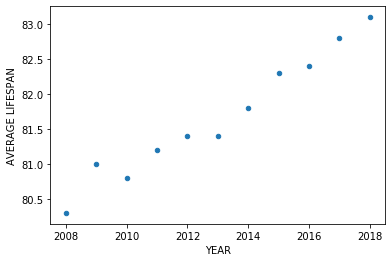

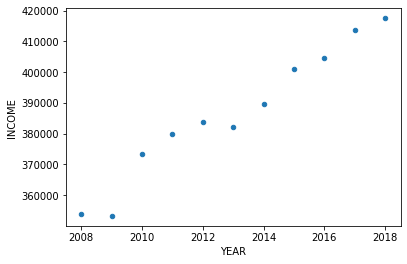

In [11]:

def plot_empl_inc(data,dataset,municipality): 
    
    if dataset == 'Average Lifespan':
        y = 'AVERAGE LIFESPAN'
    else:
        y = 'INCOME'
    
    data.loc[data["municipality"]==municipality].plot.scatter(x='YEAR',y=y,style='-o')
    
plot_empl_inc(data,"Average Lifespan","Allerød")

plot_empl_inc(data,"INCOME","Allerød")


The **interactive plot** is:

In [12]:
#empl_long = pd.wide_to_long(data, stubnames='income', i='municipality', j='YEAR').reset_index()
#empl_long

widgets.interact(plot_empl_inc, 
    
    data = widgets.fixed(data),
    dataset = widgets.Dropdown(description='Dataset', 
                              options=['Average Lifespan','Income']),
    municipality = widgets.Dropdown(description='Municipality', 
                                    options=data.municipality.unique())
                 
); 

interactive(children=(Dropdown(description='Dataset', options=('Average Lifespan', 'Income'), value='Average L…

ADD SOMETHING HERE IF THE READER SHOULD KNOW THAT E.G. SOME MUNICIPALITY IS SPECIAL.

In [34]:
map_df = gpd.read_file("KOM_MULTIPART.shp")


In [15]:
merged_munis = data.municipality.unique()
map_munis = map_df.KOMNAVN.unique()

# List of municipalities in merged_munis that are named different our map data and the opposite
diff1 = [muni for muni in merged_munis if muni not in map_munis] 
diff2 = [muni for muni in map_munis if muni not in merged_munis] 

print(f'Municipalities in our API data but named differently in the map data: {diff1}')
print(f'Municipalities in our map data but named differently in API data: {diff2}')

Municipalities in our API data but named differently in the map data: ['Copenhagen', 'Høje-Taastrup']
Municipalities in our map data but named differently in API data: ['København', 'Læsø', 'Samsø', 'Ærø', 'Fanø', 'Christiansø', 'Høje Taastrup']


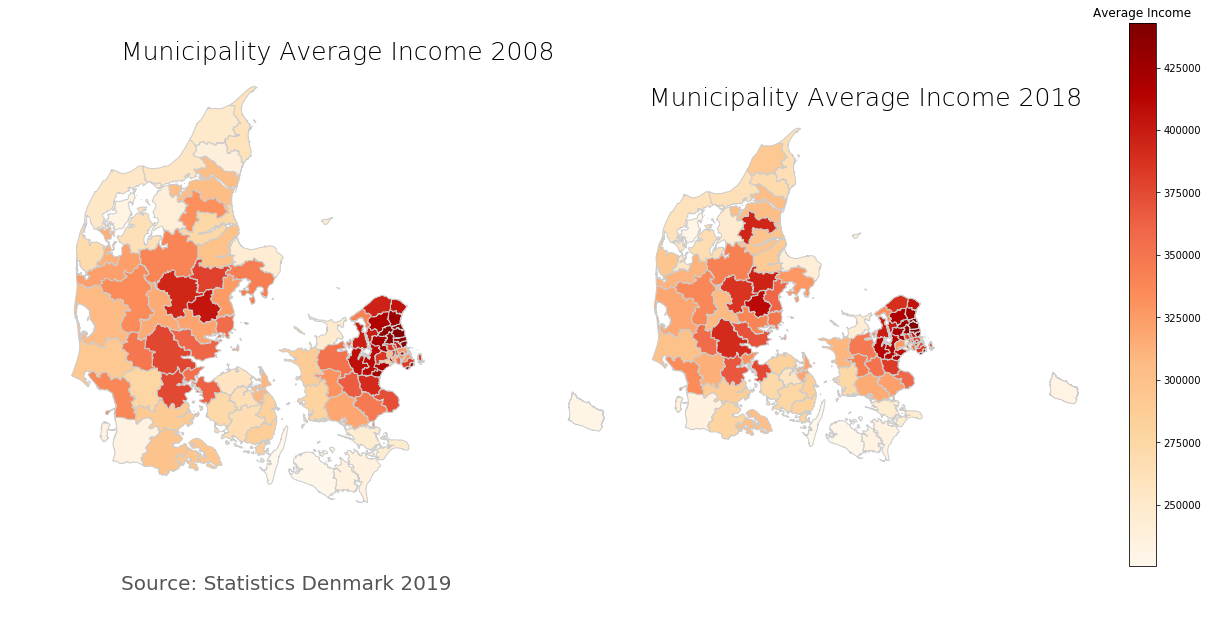

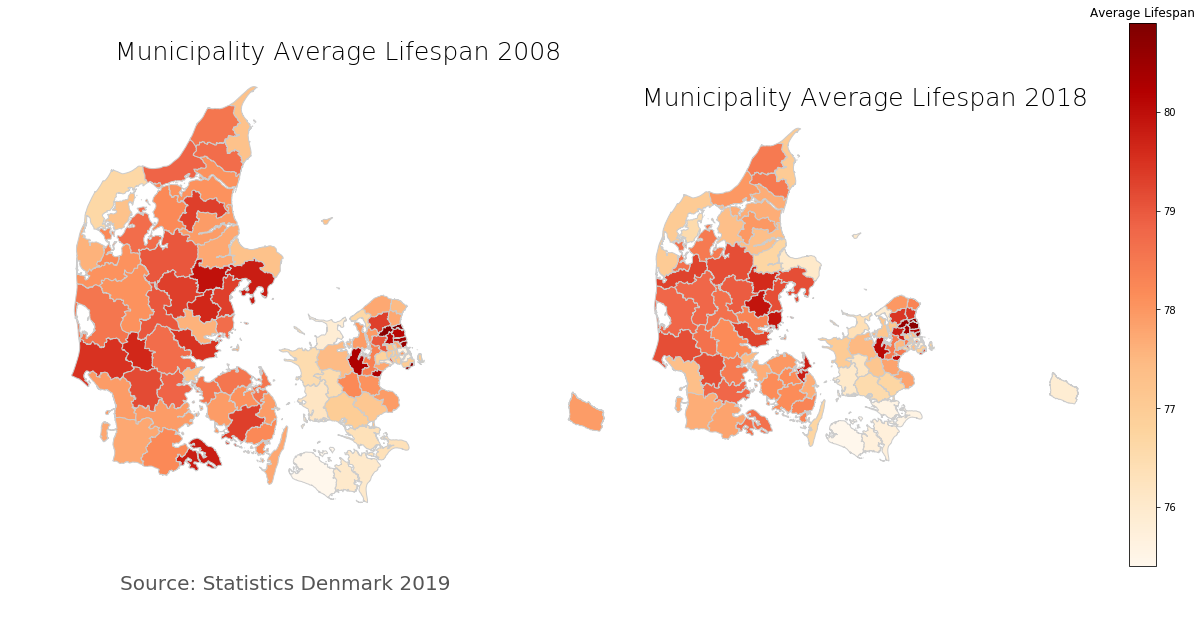

In [114]:
data2 = data.copy()

# Adjusting geo-names to merge properly
data2.loc[data2.municipality=='Copenhagen', 'municipality'] = 'København'
data2.loc[data2.municipality=='Høje-Taastrup', 'municipality'] = 'Høje Taastrup'
data2.head()


data2["AVERAGE LIFESPAN"] = data2["AVERAGE LIFESPAN"].astype(str)
data2["INCOME"] = data2["INCOME"].astype(str)

## Look at datatypes
data2.dtypes


data2_08 = data2[data2["YEAR"]==2008]
data2_18 = data2[data2["YEAR"]==2018]

merged_map = pd.merge(data2_18, data2_08, how='left', left_on='municipality', right_on='municipality')
merged_map.head()


merged_map2 = merged_map[['municipality','AVERAGE LIFESPAN_x', 'AVERAGE LIFESPAN_y', 'INCOME_x', 'INCOME_y']]
merged_map2.head()


final_map = pd.merge(map_df, merged_map2, how='left', left_on='KOMNAVN', right_on='municipality')

#Dropping missings
final_map = final_map.dropna()

final_map.head()




## The variable to visualize after is defined here
VisVarinc08 = 'INCOME_y'
VisVarinc18 = 'INCOME_x'
VisVarlvt08 = 'AVERAGE LIFESPAN_y'
VisVarlvt18 = 'AVERAGE LIFESPAN_x'



# set the range for the choropleth - this will be consistent for all plots of the same variable.
# 2007 had the most extreme values
vminUNE, vmaxUNE = merged_map['AVERAGE LIFESPAN_y'].min() , merged_map['AVERAGE LIFESPAN_y'].max()
vminFer, vmaxFer = merged_map['INCOME_y'].min() , merged_map['INCOME_y'].max()

######################################## Average Income ##########################################

# create figure, axes, size, remove whitespace and align the size of the figures in Matplotlib
side_length = 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(side_length * 2.1, side_length) , subplot_kw={'aspect': 1})
fig.subplots_adjust(hspace=0.0, wspace=0.0)

# We do not want axis to display values on our map - makes no sense
ax1.axis('off')
ax2.axis('off')

# add a title for map 1 - fix the size of the text.
ax1.set_title('Municipality Average Income 2008', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

## The actual plot is created with our colour map being set equal to OrRd
ax1=final_map.plot(column=VisVarinc08,  cmap='OrRd', ax=ax1, edgecolor='0.8')
# Attempt to get two maps of equal size
ax1.set_aspect('equal')

# create an annotation for the  data source
ax1.annotate('Source: Statistics Denmark 2019',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=20, color='#555555')

# add a title for map 2 - fix the size of the text.
ax2.set_title('Municipality Average Income 2018', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

## The actual second plot is created with our colour map being set equal to OrRd
ax2=final_map.plot(column=VisVarinc18,  cmap='OrRd', ax=ax2, edgecolor='0.8')
# Attempt to get two maps of equal size
ax2.set_aspect('equal')

## The color scale on the right is created in relation to the data with vmin and vmax. Same color theme.
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vminFer, vmax=vmaxFer))

# Empty array
sm._A = []

# Make a colour bar based on the color scale created above.
cbar = fig.colorbar(sm)

# Set a title for the color bar
cbar.ax.set_title('Average Income')

plt.show()


######################  Average LifeSpan ############################

side_length = 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(side_length * 2.1, side_length) , subplot_kw={'aspect': 1})
fig.subplots_adjust(hspace=0.0, wspace=0.0)

# We do not want axis to display values on our map - makes no sense
ax1.axis('off')
ax2.axis('off')

# add a title for map 1 - fix the size of the text.
ax1.set_title('Municipality Average Lifespan 2008', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

## The actual plot is created with our colour map being set equal to OrRd
ax1=final_map.plot(column=VisVarlvt08,  cmap='OrRd', ax=ax1, edgecolor='0.8')
# Attempt to get two maps of equal size
ax1.set_aspect('equal')

# create an annotation for the  data source
ax1.annotate('Source: Statistics Denmark 2019',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=20, color='#555555')

# add a title for map 2 - fix the size of the text.
ax2.set_title('Municipality Average Lifespan 2018', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

## The actual second plot is created with our colour map being set equal to OrRd
ax2=final_map.plot(column=VisVarlvt18,  cmap='OrRd', ax=ax2, edgecolor='0.8')
# Attempt to get two maps of equal size
ax2.set_aspect('equal')

## The color scale on the right is created in relation to the data with vmin and vmax. Same color theme.
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vminUNE, vmax=vmaxUNE))

# Empty array
sm._A = []

# Make a colour bar based on the color scale created above.
cbar = fig.colorbar(sm)

# Set a title for the color bar
cbar.ax.set_title('Average Lifespan')

plt.show()


# Analysis

To get a quick overview of the data, we show some **summary statistics by year**:

In [115]:
data.groupby('municipality').agg(['mean','std']).round(2)




YEAR       AVERAGE LIFESPAN           INCOME          
                 mean   std             mean   std       mean       std
municipality                                                           
Aabenraa         2013  3.32            79.41  0.88  270934.09  15423.48
Aalborg          2013  3.32            79.48  0.93  276069.82  15751.70
Aarhus           2013  3.32            80.23  0.85  287543.09  20405.20
Albertslund      2013  3.32            79.39  1.22  269265.82  11749.20
Allerød          2013  3.32            81.68  0.88  386573.27  21555.79
...               ...   ...              ...   ...        ...       ...
Vejen            2013  3.32            80.04  0.85  274920.73  19709.36
Vejle            2013  3.32            79.89  0.85  298470.36  19840.69
Vesthimmerlands  2013  3.32            79.58  0.90  261968.27  17160.61
Viborg           2013  3.32            80.34  0.89  285381.64  17588.32
Vordingborg      2013  3.32            77.88  0.80  264877.55  15729.21

[94 rows x 6 columns]

ADD FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

In [118]:
#df1 = data[data["YEAR"]==2018]
def plot_kommune(data,municipality):
    df = data[data["municipality"]==municipality]
   # plt.scatter(df["INCOME"],df["AVERAGE LIFESPAN"],s=5)
    df.plot.scatter(x='INCOME',y="AVERAGE LIFESPAN",style='-o')


In [119]:
widgets.interact(plot_kommune,
                 data = widgets.fixed(data),
                 municipality = widgets.Dropdown(description='Municipality',  
                                                 options = data.municipality.unique())); 

interactive(children=(Dropdown(description='Municipality', options=('Copenhagen', 'Frederiksberg', 'Ballerup',…

In [110]:
def plot_år(data,year):
    df = data[data["YEAR"]==year]
   # plt.scatter(df["INCOME"],df["AVERAGE LIFESPAN"],s=5)
    df.plot.scatter(x='INCOME',y="AVERAGE LIFESPAN",style='-o')


widgets.interact(plot_år,
                 data = widgets.fixed(data),
                 year = widgets.Dropdown(description='Year',  
                                                 options = data.YEAR.unique())); 

interactive(children=(Dropdown(description='Year', options=(2008, 2011, 2009, 2010, 2012, 2013, 2014, 2016, 20…

# Conclusion

ADD CONCISE CONLUSION.